In [1]:
# -*- coding: utf-8 -*-                                                         
'''This example uses a convolutional stack followed by a recurrent stack        
and a CTC logloss function to perform optical character recognition             
of generated text images. I have no evidence of whether it actually             
learns general shapes of text, or just is able to recognize all                 
the different fonts thrown at it...the purpose is more to demonstrate CTC       
inside of Keras.  Note that the font list may need to be updated                
for the particular OS in use.                                                   
                                                                                
This starts off with 4 letter words.  For the first 12 epochs, the              
difficulty is gradually increased using the TextImageGenerator class            
which is both a generator class for test/train data and a Keras                 
callback class. After 20 epochs, longer sequences are thrown at it              
by recompiling the model to handle a wider image and rebuilding                 
the word list to include two words separated by a space.                        
                                                                                
The table below shows normalized edit distance values. Theano uses              
a slightly different CTC implementation, hence the different results.           
                                                                                
            Norm. ED                                                            
Epoch |   TF   |   TH                                                           
------------------------                                                        
    10   0.027   0.064                                                          
    15   0.038   0.035                                                          
    20   0.043   0.045                                                          
    25   0.014   0.019                                                          
                                                                                
This requires cairo and editdistance packages:                                  
pip install cairocffi                                                           
pip install editdistance                                                        
                                                                                
Created by Mike Henry                                                           
https://github.com/mbhenry/                                                     
'''                           
!pip install cairocffi 
!pip install editdistance 
!apt install -q libcairo2-dev


    100% |████████████████████████████████| 92kB 6.0MB/s 
    100% |████████████████████████████████| 430kB 24.3MB/s 
    100% |████████████████████████████████| 163kB 34.8MB/s 
  Running setup.py bdist_wheel for cairocffi ... - done
  Stored in directory: /root/.cache/pip/wheels/3a/2e/92/89e9dcce600a1a78bebe571fdd096669cba354b29c5e1140b9
  Running setup.py bdist_wheel for pycparser ... - \ done
  Stored in directory: /root/.cache/pip/wheels/f2/9a/90/de94f8556265ddc9d9c8b271b0f63e57b26fb1d67a45564511
Successfully built cairocffi pycparser
    100% |████████████████████████████████| 174kB 12.4MB/s 
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libcairo-gobject2 libcairo-script-interpreter2 libcairo2 libice-dev
  liblzo2-2 libpixman-1-0 libpixman-1-dev libsm-dev libxcb-render0
  libxcb-render0-dev libxcb-shm0 libxcb-shm0-dev libxext-dev x11proto-xext-dev
Suggested packages:
  libcairo2-doc li

Mounted at /content/gdrive


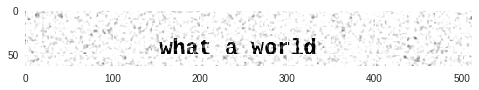

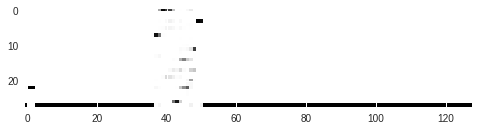

['wha owuld']
['wha owuld', 'wha owrld', 'wha wuld']


In [8]:
import os                                                                       
import itertools                                                                
import codecs                                                                   
import re                                                                       
import datetime                                                                 
import cairocffi as cairo                                                       
import editdistance                                                             
import numpy as np                                                              
from scipy import ndimage                                                       
import pylab                                                                    
from keras import backend as K                                                  
from keras.layers.convolutional import Conv2D, MaxPooling2D                     
from keras.layers import Input, Dense, Activation                               
from keras.layers import Reshape, Lambda                                        
from keras.layers.merge import add, concatenate                                 
from keras.models import Model                                                  
from keras.layers.recurrent import GRU                                          
from keras.optimizers import SGD                                                
from keras.utils.data_utils import get_file                                     
from keras.preprocessing import image                                           
import keras.callbacks    
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
                                                                                
OUTPUT_DIR = 'image_ocr'                                                        
                                                                                
# character classes and matching regex filter                                   
regex = r'^[a-z ]+$'                                                            
alphabet = u'abcdefghijklmnopqrstuvwxyz '                                       
                                                                                
np.random.seed(55)                                                              
# this creates larger "blotches" of noise which look                            
# more realistic than just adding gaussian noise                                
# assumes greyscale with pixels ranging from 0 to 1                             
                                                                                
def speckle(img):                                                               
    severity = np.random.uniform(0, 0.6)                                        
    blur = ndimage.gaussian_filter(np.random.randn(*img.shape) * severity, 1)   
    img_speck = (img + blur)                                                    
    img_speck[img_speck > 1] = 1                                                
    img_speck[img_speck <= 0] = 0                                               
    return img_speck  
  
# paints the string in a random location the bounding box                       
# also uses a random font, a slight random rotation,                            
# and a random amount of speckle noise                                          
                                                                                
def paint_text(text, w, h, rotate=False, ud=False, multi_fonts=False):          
    surface = cairo.ImageSurface(cairo.FORMAT_RGB24, w, h)                      
    with cairo.Context(surface) as context:                                     
        context.set_source_rgb(1, 1, 1)  # White                                
        context.paint()                                                         
        # this font list works in CentOS 7                                      
        if multi_fonts:                                                         
            fonts = [                                                           
                'Century Schoolbook', 'Courier', 'STIX',                        
                'URW Chancery L', 'FreeMono']                                   
            context.select_font_face(                                           
                np.random.choice(fonts),                                        
                cairo.FONT_SLANT_NORMAL,                                        
                np.random.choice([cairo.FONT_WEIGHT_BOLD, cairo.FONT_WEIGHT_NORMAL]))
        else:                                                                   
            context.select_font_face('Courier',                                 
                                     cairo.FONT_SLANT_NORMAL,                   
                                     cairo.FONT_WEIGHT_BOLD)                    
        context.set_font_size(25)                                               
        box = context.text_extents(text)                                        
        border_w_h = (4, 4)                                                     
        if box[2] > (w - 2 * border_w_h[1]) or box[3] > (h - 2 * border_w_h[0]):
            raise IOError(('Could not fit string into image.'  
                           'Max char count is too large for given image width.'))
                                                                                
        # teach the RNN translational invariance by                             
        # fitting text box randomly on canvas, with some room to rotate         
        max_shift_x = w - box[2] - border_w_h[0]                                
        max_shift_y = h - box[3] - border_w_h[1]                                
        top_left_x = np.random.randint(0, int(max_shift_x))                     
        if ud:                                                                  
            top_left_y = np.random.randint(0, int(max_shift_y))                 
        else:                                                                   
            top_left_y = h // 2                                                 
        context.move_to(top_left_x - int(box[0]), top_left_y - int(box[1]))     
        context.set_source_rgb(0, 0, 0)                                         
        context.show_text(text)                                                 
                                                                                
    buf = surface.get_data()                                                    
    a = np.frombuffer(buf, np.uint8)                                            
    a.shape = (h, w, 4)                                                         
    a = a[:, :, 0]  # grab single channel                                       
    a = a.astype(np.float32) / 255                                              
    a = np.expand_dims(a, 0)                                                    
    if rotate:                                                                  
        a = image.random_rotation(a, 3 * (w - top_left_x) / w + 1)              
    a = speckle(a)                                                              
                                                                                
    return a       
  
def shuffle_mats_or_lists(matrix_list, stop_ind=None):                          
    ret = []                                                                    
    assert all([len(i) == len(matrix_list[0]) for i in matrix_list])            
    len_val = len(matrix_list[0])                                               
    if stop_ind is None:                                                        
        stop_ind = len_val                                                      
    assert stop_ind <= len_val                                                  
                                                                                
    a = list(range(stop_ind))                                                   
    np.random.shuffle(a)                                                        
    a += list(range(stop_ind, len_val))                                         
    for mat in matrix_list:                                                     
        if isinstance(mat, np.ndarray):                                         
            ret.append(mat[a])                                                  
        elif isinstance(mat, list):                                             
            ret.append([mat[i] for i in a])                                     
        else:                                                                   
            raise TypeError('`shuffle_mats_or_lists` only supports '            
                            'numpy.array and list objects.')                    
    return ret                                                                  
                  
# Translation of characters to unique integer values                            
def text_to_labels(text):                                                       
    ret = []                                                                    
    for char in text:                                                           
        ret.append(alphabet.find(char))                                         
    return ret                                                                  
                                                                                
                                                                                
# Reverse translation of numerical classes back to characters                   
def labels_to_text(labels):                                                     
    ret = []                                                                    
    for c in labels:                                                            
        if c == len(alphabet):  # CTC Blank                                     
            ret.append("")                                                      
        else:                                                                   
            ret.append(alphabet[c])                                             
    return "".join(ret)                                                         
                                                                                
                                                                                
# only a-z and space..probably not to difficult                                 
# to expand to uppercase and symbols                                            
                                                                                
def is_valid_str(in_str):                                                       
    search = re.compile(regex, re.UNICODE).search                               
    return bool(search(in_str)) 
  
class TextImageGenerator(keras.callbacks.Callback):                             
                                                                                
    def __init__(self, monogram_file, bigram_file, minibatch_size,              
                 img_w, img_h, downsample_factor, val_split,                    
                 absolute_max_string_len=16):                                   
                                                                                
        self.minibatch_size = minibatch_size                                    
        self.img_w = img_w                                                      
        self.img_h = img_h                                                      
        self.monogram_file = monogram_file                                      
        self.bigram_file = bigram_file                                          
        self.downsample_factor = downsample_factor                              
        self.val_split = val_split                                              
        self.blank_label = self.get_output_size() - 1                           
        self.absolute_max_string_len = absolute_max_string_len                  
                                                                                
    def get_output_size(self):                                                  
        return len(alphabet) + 1   
  
    # as max_string_len grows, num_words can grow                               
    def build_word_list(self, num_words, max_string_len=None, mono_fraction=0.5):
        assert max_string_len <= self.absolute_max_string_len                   
        assert num_words % self.minibatch_size == 0                             
        assert (self.val_split * num_words) % self.minibatch_size == 0          
        self.num_words = num_words                                              
        self.string_list = [''] * self.num_words                                
        tmp_string_list = []                                                    
        self.max_string_len = max_string_len                                    
        self.Y_data = np.ones([self.num_words, self.absolute_max_string_len]) * -1
        self.X_text = []                                                        
        self.Y_len = [0] * self.num_words                                       
                                                                                
        def _is_length_of_word_valid(word):                                     
            return (max_string_len == -1 or                                     
                    max_string_len is None or                                   
                    len(word) <= max_string_len)                                
                                                                                
        # monogram file is sorted by frequency in english speech                
        with codecs.open(self.monogram_file, mode='r', encoding='utf-8') as f:  
            for line in f:                                                      
                if len(tmp_string_list) == int(self.num_words * mono_fraction): 
                    break                                                       
                word = line.rstrip()                                            
                if _is_length_of_word_valid(word):                              
                    tmp_string_list.append(word)   

                                                                                
        # bigram file contains common word pairings in english speech           
        with codecs.open(self.bigram_file, mode='r', encoding='utf-8') as f:    
            lines = f.readlines()                                               
            for line in lines:                                                  
                if len(tmp_string_list) == self.num_words:                      
                    break                                                       
                columns = line.lower().split()                                  
                word = columns[0] + ' ' + columns[1]                            
                if is_valid_str(word) and _is_length_of_word_valid(word):       
                    tmp_string_list.append(word)                                
        if len(tmp_string_list) != self.num_words:                              
            raise IOError('Could not pull enough words'                         
                          'from supplied monogram and bigram files.')           
        # interlace to mix up the easy and hard words                           
        self.string_list[::2] = tmp_string_list[:self.num_words // 2]           
        self.string_list[1::2] = tmp_string_list[self.num_words // 2:]          
                                                                                
        for i, word in enumerate(self.string_list):                             
            self.Y_len[i] = len(word)                                           
            self.Y_data[i, 0:len(word)] = text_to_labels(word)                  
            self.X_text.append(word)                                            
        self.Y_len = np.expand_dims(np.array(self.Y_len), 1)                    
                                                                                
        self.cur_val_index = self.val_split                                     
        self.cur_train_index = 0                                                
                                   
    # each time an image is requested from train/val/test, a new random         
    # painting of the text is performed                                         
    def get_batch(self, index, size, train):                                    
        # width and height are backwards from typical Keras convention          
        # because width is the time dimension when it gets fed into the RNN     
        if K.image_data_format() == 'channels_first':                           
            X_data = np.ones([size, 1, self.img_w, self.img_h])                 
        else:                                                                   
            X_data = np.ones([size, self.img_w, self.img_h, 1])                 
                                                                                
        labels = np.ones([size, self.absolute_max_string_len])                  
        input_length = np.zeros([size, 1])                                      
        label_length = np.zeros([size, 1])                                      
        source_str = []                                                         
        for i in range(size):                                                   
            # Mix in some blank inputs.  This seems to be important for         
            # achieving translational invariance                                
            if train and i > size - 4:                                          
                if K.image_data_format() == 'channels_first':                   
                    X_data[i, 0, 0:self.img_w, :] = self.paint_func('')[0, :, :].T
                else:                                                           
                    X_data[i, 0:self.img_w, :, 0] = self.paint_func('',)[0, :, :].T
                labels[i, 0] = self.blank_label                                 
                input_length[i] = self.img_w // self.downsample_factor - 2      
                label_length[i] = 1                                             
                source_str.append('')                                           
            else:                                                               
                if K.image_data_format() == 'channels_first':                   
                    X_data[i, 0, 0:self.img_w, :] = (                           
                        self.paint_func(self.X_text[index + i])[0, :, :].T)     
                else:                                                           
                    X_data[i, 0:self.img_w, :, 0] = (                           
                        self.paint_func(self.X_text[index + i])[0, :, :].T)     
                labels[i, :] = self.Y_data[index + i]                           
                input_length[i] = self.img_w // self.downsample_factor - 2      
                label_length[i] = self.Y_len[index + i]   
                source_str.append(self.X_text[index + i])                       
        inputs = {'the_input': X_data,                                          
                  'the_labels': labels,                                         
                  'input_length': input_length,                                 
                  'label_length': label_length,                                 
                  'source_str': source_str  # used for visualization only       
                  }                                                             
        outputs = {'ctc': np.zeros([size])}  # dummy data for dummy loss function
        return (inputs, outputs)  
      
    def next_train(self):                                                       
        while 1:                                                                
            ret = self.get_batch(self.cur_train_index,                          
                                 self.minibatch_size, train=True)               
            self.cur_train_index += self.minibatch_size                         
            if self.cur_train_index >= self.val_split:                          
                self.cur_train_index = self.cur_train_index % 32                
                (self.X_text, self.Y_data, self.Y_len) = shuffle_mats_or_lists( 
                    [self.X_text, self.Y_data, self.Y_len], self.val_split)     
            yield ret                                                           
                                                                                
    def next_val(self):                                                         
        while 1:                                                                
            ret = self.get_batch(self.cur_val_index,                            
                                 self.minibatch_size, train=False)              
            self.cur_val_index += self.minibatch_size                           
            if self.cur_val_index >= self.num_words:                            
                self.cur_val_index = self.val_split + self.cur_val_index % 32   
            yield ret   
         
    def on_train_begin(self, logs={}):                                          
        self.build_word_list(16000, 4, 1)                                       
        self.paint_func = lambda text: paint_text(                              
            text, self.img_w, self.img_h,                                       
            rotate=False, ud=False, multi_fonts=False)                          
                                                                                
    def on_epoch_begin(self, epoch, logs={}):                                   
        # rebind the paint function to implement curriculum learning            
        if 3 <= epoch < 6:                                                      
            self.paint_func = lambda text: paint_text(                          
                text, self.img_w, self.img_h,                                   
                rotate=False, ud=True, multi_fonts=False)                       
        elif 6 <= epoch < 9:                                                    
            self.paint_func = lambda text: paint_text(                          
                text, self.img_w, self.img_h,                                   
                rotate=False, ud=True, multi_fonts=True)                        
        elif epoch >= 9:                                                        
            self.paint_func = lambda text: paint_text(                          
                text, self.img_w, self.img_h,                                   
                rotate=True, ud=True, multi_fonts=True)                         
        if epoch >= 21 and self.max_string_len < 12:                            
            self.build_word_list(32000, 12, 0.5)                                

# the actual loss calc occurs here despite it not being                         
# an internal Keras loss function                                               
                                                                                
def ctc_lambda_func(args):                                                      
    y_pred, labels, input_length, label_length = args                           
    # the 2 is critical here since the first couple outputs of the RNN          
    # tend to be garbage:                                                       
    y_pred = y_pred[:, 2:, :]                                                   
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)         
                                                                                
                                                                                
# For a real OCR application, this should be beam search with a dictionary      
# and language model.  For this example, best path is sufficient.               
                                                                                
def decode_batch(test_func, word_batch):                                        
    out = test_func([word_batch])[0]                                            
    ret = []                                                                    
    for j in range(out.shape[0]):                                               
        out_best = list(np.argmax(out[j, 2:], 1))                               
        out_best = [k for k, g in itertools.groupby(out_best)]                  
        outstr = labels_to_text(out_best)                                       
        ret.append(outstr)                                                      
    return ret                                                                  
                                                                                
# the actual loss calc occurs here despite it not being                         
# an internal Keras loss function                                               
                                                                                
def ctc_lambda_func(args):                                                      
    y_pred, labels, input_length, label_length = args                           
    # the 2 is critical here since the first couple outputs of the RNN          
    # tend to be garbage:                                                       
    y_pred = y_pred[:, 2:, :]                                                   
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)         
                                                                                
                                                                                
# For a real OCR application, this should be beam search with a dictionary      
# and language model.  For this example, best path is sufficient.               
                                                                                
def decode_batch(test_func, word_batch):                                        
    out = test_func([word_batch])[0]                                            
    ret = []                                                                    
    for j in range(out.shape[0]):                                               
        out_best = list(np.argmax(out[j, 2:], 1))                               
        out_best = [k for k, g in itertools.groupby(out_best)]                  
        outstr = labels_to_text(out_best)                                       
        ret.append(outstr)                                                      
    return ret                                                                  
                      
                                                                                
class VizCallback(keras.callbacks.Callback):                                    
                                                                                
    def __init__(self, run_name, test_func, text_img_gen, num_display_words=6): 
        self.test_func = test_func                                              
        self.output_dir = os.path.join(                                         
            OUTPUT_DIR, run_name)                                               
        self.text_img_gen = text_img_gen                                        
        self.num_display_words = num_display_words                              
        if not os.path.exists(self.output_dir):                                 
            os.makedirs(self.output_dir)                                        
                                                                                
    def show_edit_distance(self, num):                                          
        num_left = num                                                          
        mean_norm_ed = 0.0                                                      
        mean_ed = 0.0                                                           
        while num_left > 0:                                                     
            word_batch = next(self.text_img_gen)[0]                             
            num_proc = min(word_batch['the_input'].shape[0], num_left)          
            decoded_res = decode_batch(self.test_func,                          
                                       word_batch['the_input'][0:num_proc])     
            for j in range(num_proc):                                           
                edit_dist = editdistance.eval(decoded_res[j],                   
                                              word_batch['source_str'][j])      
                mean_ed += float(edit_dist)                                     
                mean_norm_ed += float(edit_dist) / len(word_batch['source_str'][j])
            num_left -= num_proc                                                
        mean_norm_ed = mean_norm_ed / num                                       
        mean_ed = mean_ed / num                                                 
        print('\nOut of %d samples:  Mean edit distance:'                       
              '%.3f Mean normalized edit distance: %0.3f'                       
              % (num, mean_ed, mean_norm_ed))   
        
    def on_epoch_end(self, epoch, logs={}):                                     
        self.model.save_weights(                                                
            os.path.join(self.output_dir, 'weights%02d.h5' % (epoch)))          
        self.show_edit_distance(256)                                            
        word_batch = next(self.text_img_gen)[0]                                 
        res = decode_batch(self.test_func,                                      
                           word_batch['the_input'][0:self.num_display_words])   
        if word_batch['the_input'][0].shape[0] < 256:                           
            cols = 2                                                            
        else:                                                                   
            cols = 1                                                            
        for i in range(self.num_display_words):                                 
            pylab.subplot(self.num_display_words // cols, cols, i + 1)          
            if K.image_data_format() == 'channels_first':                       
                the_input = word_batch['the_input'][i, 0, :, :]                 
            else:                                                               
                the_input = word_batch['the_input'][i, :, :, 0]                 
            pylab.imshow(the_input.T, cmap='Greys_r')                           
            pylab.xlabel(                                                       
                'Truth = \'%s\'\nDecoded = \'%s\'' %                            
                (word_batch['source_str'][i], res[i]))                          
        fig = pylab.gcf()                                                       
        fig.set_size_inches(10, 13)                                             
        pylab.savefig(os.path.join(self.output_dir, 'e%02d.png' % (epoch)))     
        pylab.close()   
        
def train(run_name, start_epoch, stop_epoch, img_w):                            
    # Input Parameters                                                          
    img_h = 64                                                                  
    words_per_epoch = 16000                                                     
    val_split = 0.2                                                             
    val_words = int(words_per_epoch * (val_split))                              
                                                                                
    # Network parameters                                                        
    conv_filters = 16                                                           
    kernel_size = (3, 3)                                                        
    pool_size = 2                                                               
    time_dense_size = 32                                                        
    rnn_size = 512                                                              
    minibatch_size = 32                                                         
                                                                                
    if K.image_data_format() == 'channels_first':                               
        input_shape = (1, img_w, img_h)                                         
    else:                                                                       
        input_shape = (img_w, img_h, 1)                                         
                                                                                
    fdir = os.path.dirname(                                                     
        get_file('wordlists.tgz',                                               
                 origin='http://www.mythic-ai.com/datasets/wordlists.tgz',      
                 untar=True))                                                   
                                                                                
    img_gen = TextImageGenerator(                                               
        monogram_file=os.path.join(fdir, 'wordlist_mono_clean.txt'),            
        bigram_file=os.path.join(fdir, 'wordlist_bi_clean.txt'),                
        minibatch_size=minibatch_size,                                          
        img_w=img_w,                                                            
        img_h=img_h,    
        downsample_factor=(pool_size ** 2),                                     
        val_split=words_per_epoch - val_words)                                  
    act = 'relu'                                                                
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')    
    inner = Conv2D(conv_filters, kernel_size, padding='same',                   
                   activation=act, kernel_initializer='he_normal',              
                   name='conv1')(input_data)                                    
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)  
    inner = Conv2D(conv_filters, kernel_size, padding='same',                   
                   activation=act, kernel_initializer='he_normal',              
                   name='conv2')(inner)                                         
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)  
                                                                                
    conv_to_rnn_dims = (img_w // (pool_size ** 2),                              
                        (img_h // (pool_size ** 2)) * conv_filters)             
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)       
                                                                                
    # cuts down input size going into RNN:                                      
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)        
                                                                         
    # Two layers of bidirectional GRUs                                          
    # GRU seems to work as well, if not better than LSTM:                       
    gru_1 = GRU(rnn_size, return_sequences=True,                                
                kernel_initializer='he_normal', name='gru1')(inner)             
    gru_1b = GRU(rnn_size, return_sequences=True,                               
                 go_backwards=True, kernel_initializer='he_normal',             
                 name='gru1_b')(inner)                                          
    gru1_merged = add([gru_1, gru_1b])                                          
    gru_2 = GRU(rnn_size, return_sequences=True,                                
                kernel_initializer='he_normal', name='gru2')(gru1_merged)       
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True,            
                 kernel_initializer='he_normal', name='gru2_b')(gru1_merged)    
                                                                                
    # transforms RNN output to character activations:                           
    inner = Dense(img_gen.get_output_size(), kernel_initializer='he_normal',    
                  name='dense2')(concatenate([gru_2, gru_2b]))                  
    y_pred = Activation('softmax', name='softmax')(inner)                       
    predict_model = Model(inputs=input_data, outputs=y_pred)
    predict_model.summary()                          
                                                                                
    labels = Input(name='the_labels',                                           
                   shape=[img_gen.absolute_max_string_len], dtype='float32')    
    input_length = Input(name='input_length', shape=[1], dtype='int64')         
    label_length = Input(name='label_length', shape=[1], dtype='int64')         
    # Keras doesn't currently support loss funcs with extra parameters          
    # so CTC loss is implemented in a lambda layer                              
    loss_out = Lambda(                                                          
        ctc_lambda_func, output_shape=(1,),                                     
        name='ctc')([y_pred, labels, input_length, label_length])               
                                                                                
    # clipnorm seems to speeds up convergence                                   
    sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5) 
 
    model = Model(inputs=[input_data, labels, input_length, label_length],      
                  outputs=loss_out)                                             
                                                                                
    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss   
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)   
    if start_epoch > 0:                                                         
        weight_file = os.path.join(                                             
            OUTPUT_DIR,                                                         
            os.path.join(run_name, 'weights%02d.h5' % (start_epoch - 1)))       
        model.load_weights(weight_file)      
        # captures output of softmax so we can decode the output during visualization
    test_func = K.function([input_data], [y_pred])                              
                                                                                
    viz_cb = VizCallback(run_name, test_func, img_gen.next_val())               
                                                                                
    model.fit_generator(                                                        
        generator=img_gen.next_train(),                                         
        steps_per_epoch=(words_per_epoch - val_words) // minibatch_size,        
        epochs=stop_epoch,                                                      
        validation_data=img_gen.next_val(),                                     
        validation_steps=val_words // minibatch_size,                           
        callbacks=[viz_cb, img_gen],                                            
        initial_epoch=start_epoch)   
    model.save_weights("ocr_crc_weight.h5")
    
        
def get_predict_model(img_w,pre_trained_file ):                            
    # Input Parameters                                                          
    img_h = 64                                                                  
    words_per_epoch = 16000                                                     
    val_split = 0.2                                                             
    val_words = int(words_per_epoch * (val_split))                              
                                                                                
    # Network parameters                                                        
    conv_filters = 16                                                           
    kernel_size = (3, 3)                                                        
    pool_size = 2                                                               
    time_dense_size = 32                                                        
    rnn_size = 512                                                              
    minibatch_size = 32                                                         
                                                                                
    if K.image_data_format() == 'channels_first':                               
        input_shape = (1, img_w, img_h)                                         
    else:                                                                       
        input_shape = (img_w, img_h, 1)                                         
                                                                                
    fdir = os.path.dirname(                                                     
        get_file('wordlists.tgz',                                               
                 origin='http://www.mythic-ai.com/datasets/wordlists.tgz',      
                 untar=True))                                                   
                                                                                
    img_gen = TextImageGenerator(                                               
        monogram_file=os.path.join(fdir, 'wordlist_mono_clean.txt'),            
        bigram_file=os.path.join(fdir, 'wordlist_bi_clean.txt'),                
        minibatch_size=minibatch_size,                                          
        img_w=img_w,                                                            
        img_h=img_h,    
        downsample_factor=(pool_size ** 2),                                     
        val_split=words_per_epoch - val_words)                                  
    act = 'relu'                                                                
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')    
    inner = Conv2D(conv_filters, kernel_size, padding='same',                   
                   activation=act, kernel_initializer='he_normal',              
                   name='conv1')(input_data)                                    
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)  
    inner = Conv2D(conv_filters, kernel_size, padding='same',                   
                   activation=act, kernel_initializer='he_normal',              
                   name='conv2')(inner)                                         
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)  
                                                                                
    conv_to_rnn_dims = (img_w // (pool_size ** 2),                              
                        (img_h // (pool_size ** 2)) * conv_filters)             
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)       
                                                                                
    # cuts down input size going into RNN:                                      
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)        
                                                                         
    # Two layers of bidirectional GRUs                                          
    # GRU seems to work as well, if not better than LSTM:                       
    gru_1 = GRU(rnn_size, return_sequences=True,                                
                kernel_initializer='he_normal', name='gru1')(inner)             
    gru_1b = GRU(rnn_size, return_sequences=True,                               
                 go_backwards=True, kernel_initializer='he_normal',             
                 name='gru1_b')(inner)                                          
    gru1_merged = add([gru_1, gru_1b])                                          
    gru_2 = GRU(rnn_size, return_sequences=True,                                
                kernel_initializer='he_normal', name='gru2')(gru1_merged)       
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True,            
                 kernel_initializer='he_normal', name='gru2_b')(gru1_merged)    
                                                                                
    # transforms RNN output to character activations:                           
    inner = Dense(img_gen.get_output_size(), kernel_initializer='he_normal',    
                  name='dense2')(concatenate([gru_2, gru_2b]))                  
    y_pred = Activation('softmax', name='softmax')(inner)                       
    predict_model = Model(inputs=input_data, outputs=y_pred)
    #predict_model.summary()                          
                                                                                
    labels = Input(name='the_labels',                                           
                   shape=[img_gen.absolute_max_string_len], dtype='float32')    
    input_length = Input(name='input_length', shape=[1], dtype='int64')         
    label_length = Input(name='label_length', shape=[1], dtype='int64')         
    # Keras doesn't currently support loss funcs with extra parameters          
    # so CTC loss is implemented in a lambda layer                              
    loss_out = Lambda(                                                          
        ctc_lambda_func, output_shape=(1,),                                     
        name='ctc')([y_pred, labels, input_length, label_length])               
                                                                                
    # clipnorm seems to speeds up convergence                                   
    sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5) 
 
    model = Model(inputs=[input_data, labels, input_length, label_length],      
                  outputs=loss_out)                                             
                                                                                
    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss   
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)   
                                         
    # captures output of softmax so we can decode the output during visualization
    test_func = K.function([input_data], [y_pred])                              
                                                                                
    #viz_cb = VizCallback(run_name, test_func, img_gen.next_val())               
                                                                                
    model.load_weights(pre_trained_file)
    
    model_p = Model(inputs=input_data, outputs=y_pred)
    
    return model_p
    
def decode_predict_ctc(out, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
      beam_width = top_paths
    for i in range(top_paths):
      lables = K.get_value(K.ctc_decode(out, input_length=np.ones(out.shape[0])*out.shape[1],
                           greedy=False, beam_width=beam_width, top_paths=top_paths)[0][i])[0]
      text = labels_to_text(lables)
      results.append(text)
    return results
  
def predict_a_image(model_p, a, top_paths = 1):
  c = np.expand_dims(a.T, axis=0)
  net_out_value = model_p.predict(c)
  top_pred_texts = decode_predict_ctc(net_out_value, top_paths)
  return top_pred_texts

def self_train():
    run_name = datetime.datetime.now().strftime('%Y:%m:%d:%H:%M:%S')            
    train(run_name, 0, 20, 128)                                                 
    # increase to wider images and start at epoch 20.                           
    # The learned weights are reloaded                                          
    train(run_name, 20, 25, 512)  
    
def demo_predict_a_imgage(w, img):                                              
    h = 64                                                                      
    model_p = get_predict_model(w, '/content/gdrive/My Drive/ai/ocr_crc_weight.h5')
                                                                                
    b = img.reshape((h, w))                                                     
    plt.imshow(b, cmap='Greys_r')                                               
    plt.show()                                                                  
                                                                                
    c = np.expand_dims(img.T, axis=0)                                           
    # our prediction output from the model                                      
    net_out_value = model_p.predict(c)                                          
    # result graph                                                              
    plt.imshow(net_out_value[0].T, cmap='binary', interpolation='nearest')      
    plt.show()                                                                  
                                                                                
    pred_texts = decode_predict_ctc(net_out_value)                              
    print( pred_texts )                                                         
                                                                                
    # top beam search result                                                    
    top_pred_texts = predict_a_image(model_p, img, top_paths = 3)               
    print(top_pred_texts)                                                       
                                               
              

def self_test(text):
    h = 64
    w = 512
    # out generate text img                                                     
    a = paint_text(text,h = h, w = w)                                           
    demo_predict_a_imgage(w, a)                                                 
                                 
      
def scale(w, h, x, y, maximum=True):
        nw = y * w / h
        nh = x * h / w
        if maximum ^ (nw >= x):
                return nw or 1, y
        return x, nh or 1
      
def ocr_img(filename):
    # buggy plt, need to convert RGBA from   a monochrome file, png
    img = Image.open(filename)
    img.load()
    
    img = img.convert('P')
    #plt.imshow(img)
    
    #img = img.convert(mode="P")
    o_img_w, o_img_h = img.size

    
    #plt.imshow(img)
    
    h = 64
    w = 512

    text_h = 48
    
    
    new_w, new_h= scale(w, text_h, o_img_w, o_img_h, False)
    
    
    new_w = int(new_w)
    new_h = int(new_h)
    print(new_w, new_h)
    
    #img = img.resize((new_w, new_h), Image.ANTIALIAS)
    #img = img.resize((wsize, text_h), Image.ANTIALIAS)
    img_w, img_h = img.size
    
    #n_img = Image.new("RGB", (w, h), (255,255,255))
    n_img = Image.new("P", (w, h), 255)
    
    bg_w, bg_h = n_img.size
    offset =((bg_w - img_w) // 2, (bg_h - img_h) // 2)
    n_img.paste(img, offset)
    #background.save('out.png')
    
    #convert to black/white
    #n_img = n_img.convert('P')
    
    plt.imshow(n_img, cmap='Greys_r')
      
    #n_img = n_img.crop((0,0,w,h))
    #plt.imshow(n_img, cmap='Greys_r')
    
    a = np.asarray( n_img, dtype="uint8" )/255.
    
    # how to reshape to 1 color and refill 0 if less than 64*512
    
    print(a.shape)
    
    #a1 = paint_text('what a test',h = h, w = w)
    #print(a1.shape)
    
    
    
    a.resize((1,h,w))
    
    print(a.shape)
      
    b = a.reshape((h, w))
    plt.imshow(b, cmap='Greys_r')
    plt.show()

    demo_predict_a_imgage(w, a)
    
    
    
if __name__ == '__main__':                                                      
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    
    #run_name = datetime.datetime.now().strftime('%Y:%m:%d:%H:%M:%S')       
    #run_name =  "ocr_crc_weight.h5"
    #train(run_name, 0, 20, 128) 
    #train(run_name, 20, 25, 512) 
    #train(run_name, 0, 1, 128) 
    # increase to wider images and start at epoch 20.                           
    # The learned weights are reloaded                                          
    #train(run_name, 25, 50, 512)  
    
    self_test("what a world")  
    
    #uploaded = files.upload()
    #print( os.getcwd() )
    #print( os.listdir(os.getcwd()) )
    #files.download('/content/ocr_crc_weight.h5')
    #files.download('/content/ocr_crc_weight.h5')
    
    #ocr_img("/content/gdrive/My Drive/ai/line_0.png")
    #ocr_img("/content/gdrive/My Drive/ai/text_20.png")
    #filename = "/content/gdrive/My Drive/ai/line_6.png"
    #ocr_img(filename)
    #self_test("hello world")
    #self_train()

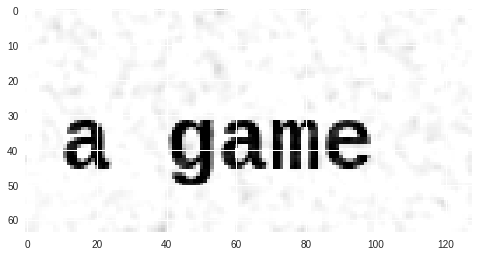

In [15]:
# import pylab
import matplotlib.pyplot as plt

h = 64
w = 128
a = paint_text('a game',h = h, w = w)
b = a.reshape((h, w))
plt.imshow(b, cmap='Greys_r')
plt.show()

c = np.expand_dims(a.T, axis=0)

In [2]:
from google.colab import files
import os                                                                       

print( os.getcwd() )
print( os.listdir(os.getcwd()) )
files.download('/content/ocr_crc_weight.h5')

/content
['sample_data', '.config']


FileNotFoundError: ignored